# Import libraries

In [1]:
import requests
import json
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon, Polygon
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype

# Read Datasets

In [2]:
la_trees_fire_temp = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_temp.csv")
la_trees_fire_unique_grouped = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_unique_grouped.csv")
la_fire_0_gdf_clipped = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_fire_0_gdf_clipped.csv")
la_trees_fire_92768 = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_92768.csv")
la_trees_combined = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_combined.csv")
la_boundary = gpd.read_file('/Users/davidliu/Desktop/IASC-2025/data/la_city_boundary.geojson')

/var/folders/xr/69vk_5_966g8wxf_bwqt42t80000gn/T/ipykernel_24701/858525148.py:4: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  la_trees_fire_92768 = pd.read_csv("/Users/davidliu/Desktop/IASC-2025/data/la_trees_fire_92768.csv")


# Visualized the tree density in LA

In [3]:
la_trees_combined.shape

(848194, 5)

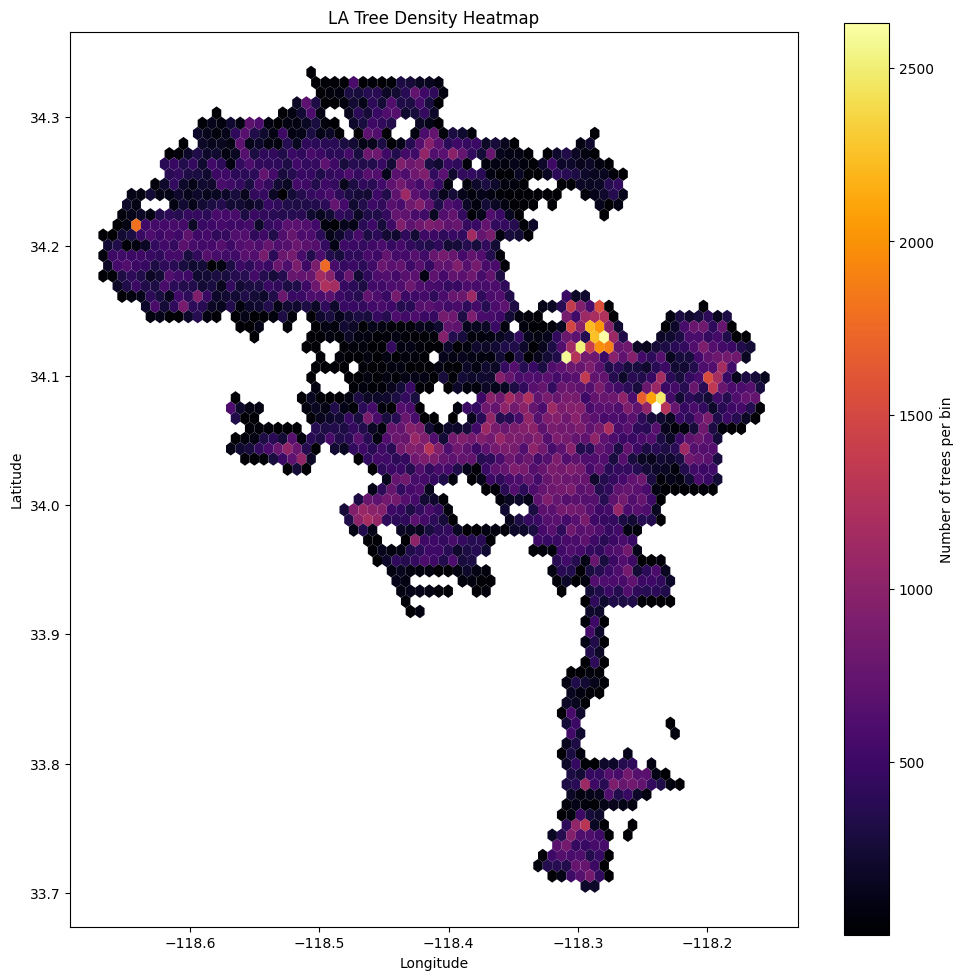

In [4]:
import matplotlib.pyplot as plt

# 1. Extract your coordinates
x = la_trees_combined['Longitude'].values
y = la_trees_combined['Latitude'].values

# 2. Plot with hexbin
fig, ax = plt.subplots(figsize=(10, 10))
hb = ax.hexbin(
    x, y,
    gridsize=70,          # try 100–300 depending on resolution vs speed
    mincnt=1,              # ignore empty bins
    cmap='inferno',        # intense color for high density
    linewidths=0,          # no bin borders
    reduce_C_function='count'
)

# 3. Tidy up
ax.set_title("LA Tree Density Heatmap")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal', 'box')
cb = fig.colorbar(hb, ax=ax)
cb.set_label('Number of trees per bin')

plt.tight_layout()
plt.show()


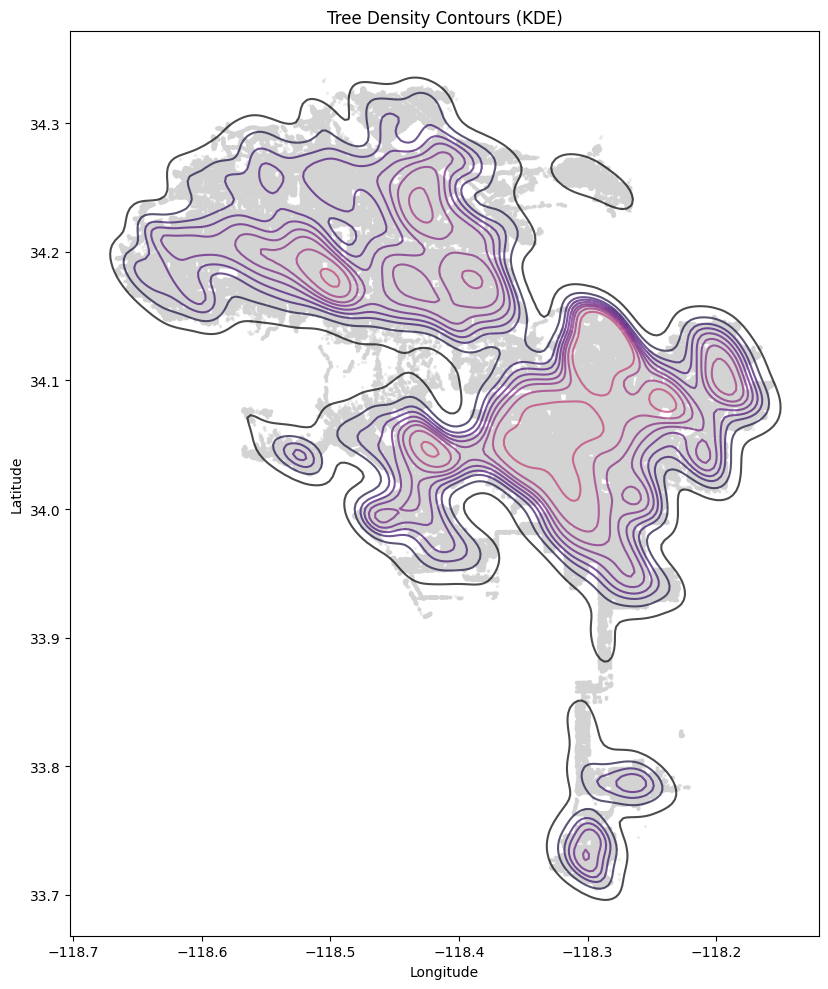

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

x = la_trees_combined['Longitude']
y = la_trees_combined['Latitude']

fig, ax = plt.subplots(figsize=(10,10))
# scatter lightly underneath (optional)
ax.scatter(x, y, s=2, color='lightgray', alpha=0.3)

# overplot KDE contours
sns.kdeplot(
    x=x, y=y,
    ax=ax,
    cmap="magma",
    levels=10,
    thresh=0.05,
    alpha=0.7
)

ax.set_title("Tree Density Contours (KDE)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_aspect('equal')
plt.tight_layout()
plt.show()


# Visualized the fire in LA

In [6]:
import geopandas as gpd
from shapely.geometry import shape, MultiPolygon, Polygon
from shapely import wkt
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype
import requests
import json
import os
import matplotlib.pyplot as plt
from shapely.geometry import shape, MultiPolygon, Polygon
import pandas as pd
import geopandas as gpd
from shapely import wkt
from pandas.api.types import is_object_dtype
from pandas.api.types import CategoricalDtype

In [7]:
def read_geo_df(path: str):
    df = pd.read_csv(path)
    df['geometry'] = df['geometry'].apply(wkt.loads)
    gdf = gpd.GeoDataFrame(df, geometry='geometry')
    gdf.set_crs("EPSG:4326", inplace=True)
    return df, gdf

def print_df_info(df, name):
    print(f"--- Info for {name} ---")
    print("Dimensions:", df.shape)
    print("Columns:", df.columns.tolist())
    print("Unique YEAR_ values:", df['YEAR_'].unique())
    print()
    
def filter_fires_in_boundary(fire_gdf, boundary_gdf, mode="within"):
    fire_gdf = fire_gdf.to_crs(boundary_gdf.crs)
    boundary_union = boundary_gdf.geometry.union_all()
    
    if mode == "within":
        filtered_fires = fire_gdf[fire_gdf.geometry.within(boundary_union)]
    elif mode == "intersects":
        filtered_fires = fire_gdf[fire_gdf.geometry.intersects(boundary_union)]
    else:
        raise ValueError("mode must be 'within' or 'intersects'")
    
    return filtered_fires

def fix_invalid_geometries(gdf):
    # Attempt to fix invalid geometries using buffer(0)
    gdf['geometry'] = gdf.geometry.buffer(0)
    # Drop any that remain invalid (optional)
    gdf = gdf[gdf.is_valid]
    return gdf

def clip_fires_to_boundary(fire_gdf, boundary_gdf):
    fire_gdf = fire_gdf.to_crs(boundary_gdf.crs)
    fire_gdf = fix_invalid_geometries(fire_gdf)
    
    boundary_union = boundary_gdf.geometry.union_all()
    clipped_fires = gpd.clip(fire_gdf, boundary_union)
    return clipped_fires

In [8]:
ca_fire_0_df, ca_fire_0_gdf = read_geo_df("/Users/davidliu/Desktop/IASC-2025/data/california_fire_perimeters_0.csv")

# Filter out the fires around and inside the LA city boundary
la_fire_0_gdf = filter_fires_in_boundary(ca_fire_0_gdf, la_boundary, mode="intersects")

# Clip the fires that are strictly inside the LA city
la_fire_0_gdf_clipped = clip_fires_to_boundary(ca_fire_0_gdf, la_boundary)

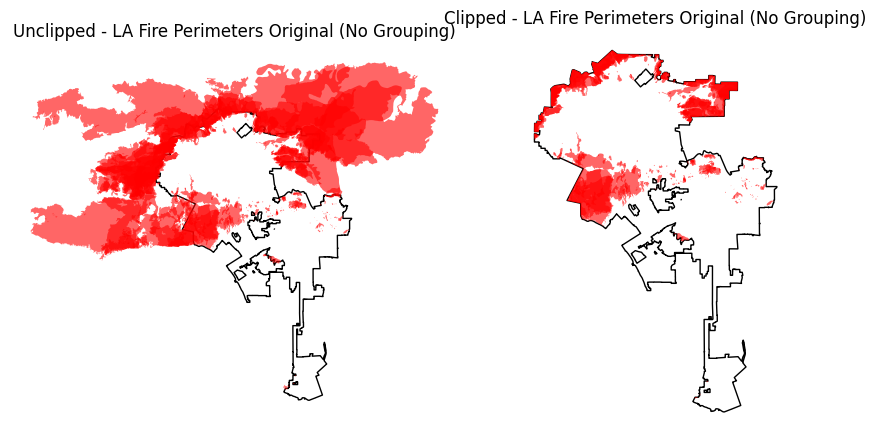

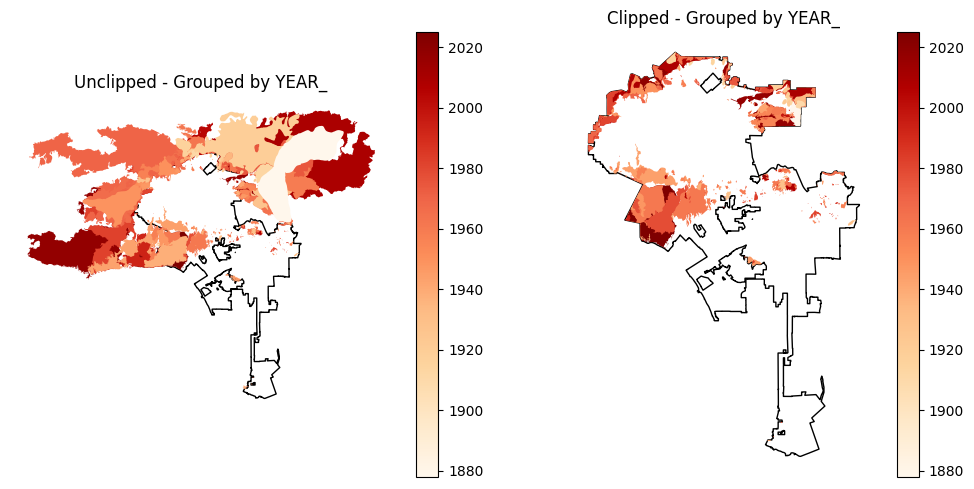

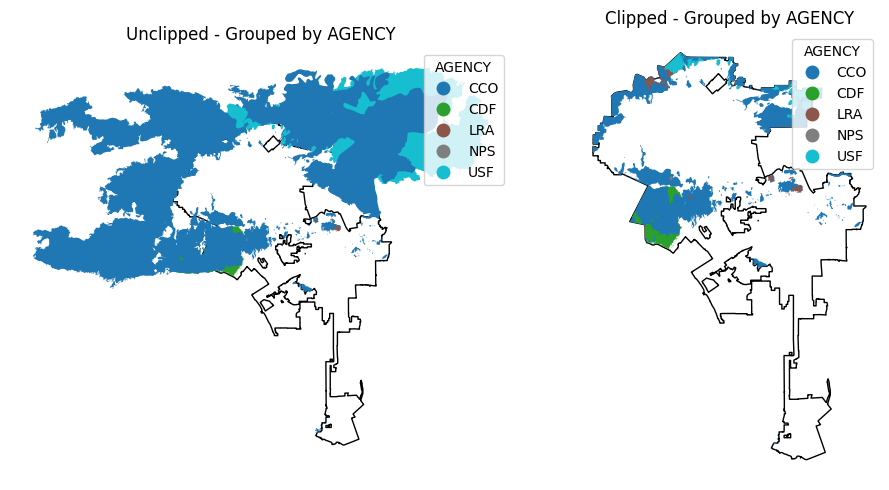

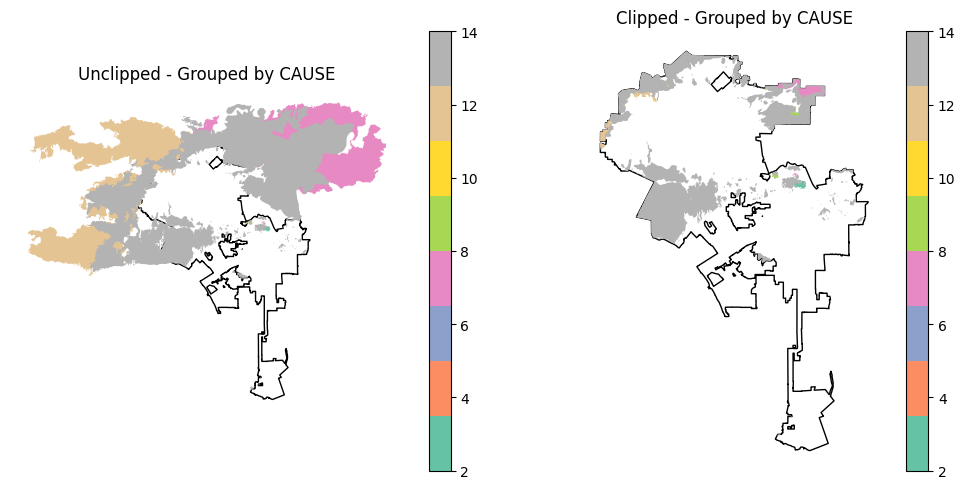

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(9, 4.5))

# Unclipped original
la_boundary.plot(ax=axes[0], color='none', edgecolor='black')
la_fire_0_gdf.plot(ax=axes[0], color='red', alpha=0.6)
axes[0].set_title('Unclipped - LA Fire Perimeters Original (No Grouping)')
axes[0].axis('off')

# Clipped original
la_boundary.plot(ax=axes[1], color='none', edgecolor='black')
la_fire_0_gdf_clipped.plot(ax=axes[1], color='red', alpha=0.6)
axes[1].set_title('Clipped - LA Fire Perimeters Original (No Grouping)')
axes[1].axis('off')

plt.tight_layout()
plt.show()

group_cols = ['YEAR_', 'AGENCY', 'CAUSE']
colormaps = ['OrRd', 'tab10', 'Set2']

for group_col, cmap in zip(group_cols, colormaps):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    col_dtype = la_fire_0_gdf[group_col].dtype
    is_categorical = is_object_dtype(col_dtype) or isinstance(col_dtype, CategoricalDtype)

    legend_args = {'legend': True}
    if is_categorical:
        legend_args['legend_kwds'] = {'title': group_col}

    # Unclipped plot
    la_boundary.plot(ax=axes[0], color='none', edgecolor='black')
    la_fire_0_gdf.plot(
        ax=axes[0],
        column=group_col,
        cmap=cmap,
        **legend_args
    )
    axes[0].set_title(f'Unclipped - Grouped by {group_col}')
    axes[0].axis('off')

    # Clipped plot
    la_boundary.plot(ax=axes[1], color='none', edgecolor='black')
    la_fire_0_gdf_clipped.plot(
        ax=axes[1],
        column=group_col,
        cmap=cmap,
        **legend_args
    )
    axes[1].set_title(f'Clipped - Grouped by {group_col}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

In [10]:
la_trees_fire_unique_grouped["FIRE_SIZE_CATEGORY"]

0         Large
1         Large
2        Medium
3         Small
4         Large
          ...  
51891    Medium
51892    Medium
51893    Medium
51894    Medium
51895    Medium
Name: FIRE_SIZE_CATEGORY, Length: 51896, dtype: object

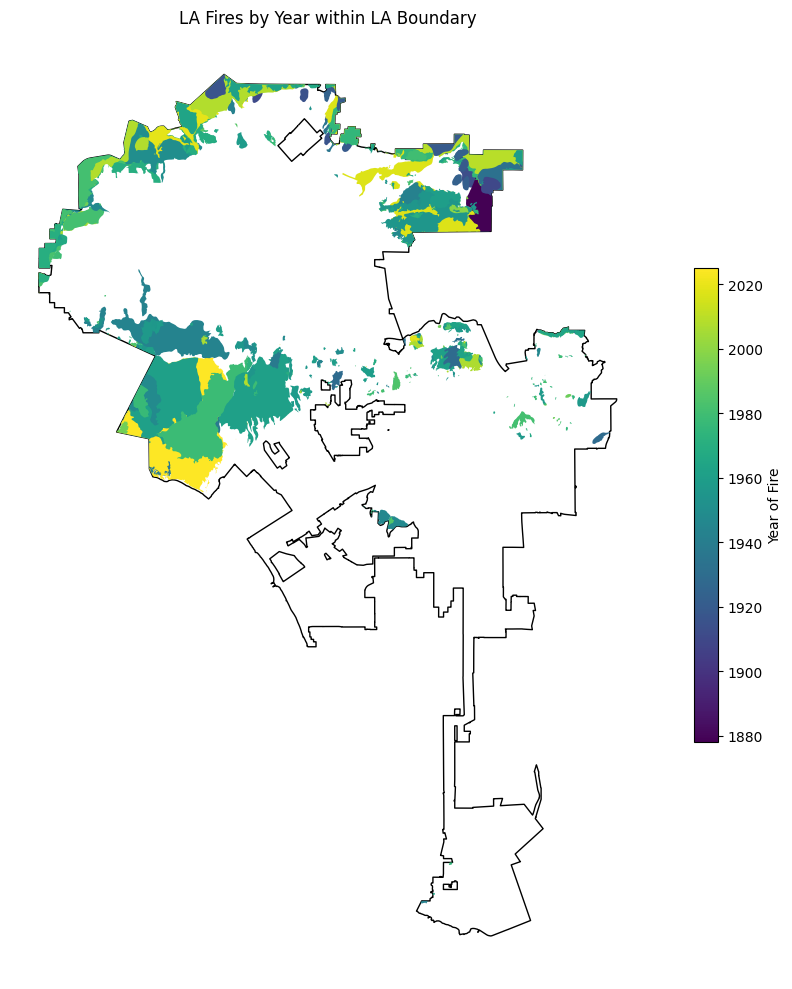

In [16]:
import matplotlib.pyplot as plt

# Plot LA boundary and overlay fires colored by year
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the LA boundary
la_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

# Plot the fire points, colored by YEAR_
la_fire_0_gdf_clipped.plot(
    column='YEAR_',
    ax=ax,
    cmap='viridis',
    markersize=20,
    legend=True,
    legend_kwds={'label': "Year of Fire", 'shrink': 0.5}
)

ax.set_title('LA Fires by Year within LA Boundary')
ax.set_axis_off()
plt.tight_layout()
plt.show()


In [11]:
def categorize_fire_size_simple(acres):
    if acres < 100:
        return 'Small'
    elif acres < 1000:
        return 'Medium'
    elif acres < 10000:
        return 'Large'
    else:
        return 'Very Large'

In [18]:
la_fire_0_gdf_clipped.columns

Index(['OBJECTID', 'YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME',
       'INC_NUM', 'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE',
       'GIS_ACRES', 'COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'FIRE_NUM',
       'COMPLEX_ID', 'DECADES', 'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

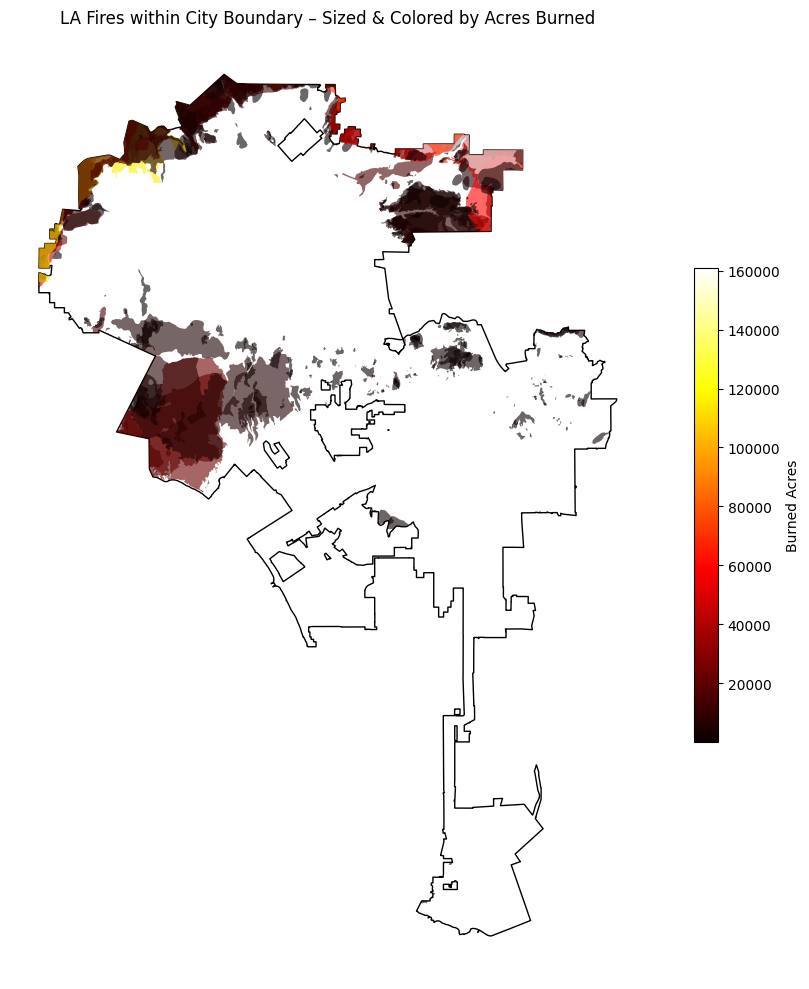

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure your GeoDataFrames are loaded: la_boundary, la_fire_0_gdf_clipped
# And that the burned‐area column is named 'Acres' in la_fire_0_gdf_clipped

fig, ax = plt.subplots(figsize=(10, 10))

# 1. Plot LA boundary
la_boundary.plot(ax=ax, facecolor='none', edgecolor='black', linewidth=1)

# 2. Prepare marker sizes (sqrt scale to temper large values)
acres = la_fire_0_gdf_clipped['GIS_ACRES']
sizes = np.sqrt(acres) * 0.5  # adjust multiplier for best visibility

# 3. Plot fires: color + size by Acres
la_fire_0_gdf_clipped.plot(
    ax=ax,
    column='GIS_ACRES',
    cmap='hot',
    markersize=sizes,
    alpha=0.6,
    legend=True,
    legend_kwds={'label': 'Burned Acres', 'shrink': 0.5}
)

ax.set_title('LA Fires within City Boundary – Sized & Colored by Acres Burned')
ax.set_axis_off()
plt.tight_layout()
plt.show()
